<a href="https://colab.research.google.com/github/sofiarochinhauab/convolutional-network/blob/main/convolutionalnetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [25]:
import os
import pandas as pd

import seaborn as sns
import cv2
import tensorflow as tf

#for the zip files
import zipfile

#for copy the images to a new path
import shutil

#for check if the image is ok or not
import imghdr

import numpy as np
import matplotlib.pyplot as plt

#for the deep model
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

#for testing the model
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy


In [2]:
#avoid OOM erros by setting GPU memory consumption growth

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

### import the images


In [3]:
#import json config in the kaggle profile for api
#profile -> api -> token -> upload the json

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sofiarochinha","key":"7cbc7c43a6e3b368dd98a42839ee53f4"}'}

In [4]:
#create a new directory for the json file

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#import all the images
!kaggle datasets download -d faizalkarim/cleandirty-road-classification

 99% 71.0M/71.6M [00:03<00:00, 30.8MB/s]
100% 71.6M/71.6M [00:03<00:00, 20.5MB/s]


In [5]:
#unzip all the files
zip_ref = zipfile.ZipFile('cleandirty-road-classification.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

### Prepare the data


In [6]:
#get all the images
path_images = '/content/files/Images/Images/'
img_names = os.listdir(path_images)

#the new paths for the selected data
!mkdir -p '/content/images/clean'
!mkdir -p '/content/images/dirty'

path_clean_image = '/content/images/clean/'
path_dirty_image = '/content/images/dirty/'


Separe the images int two classes: clean and littered.

In [7]:

for img_name in img_names:
    # Caminho completo para a imagem
    img_path = os.path.join(path_images, img_name)

    # Carregar a imagem
    img = cv2.imread(img_path)

    # Adicionar o rótulo correspondente à lista de rótulos
    if 'clean' in img_name:
       shutil.copy(img_path, path_clean_image)
    elif "dirty" in img_name:
       shutil.copy(img_path, path_dirty_image)

See if the data is not corrupted


In [8]:
#files formats that are allowed by tensor
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

#path with selected images
path = '/content/images/'


# check if the image is ok
# if not remove it
# not every image that have a extension 'jpeg' for example, is a jpeg file

for image_class in os.listdir(path):
  for image in os.listdir(os.path.join(path, image_class)):
    image_path = os.path.join(path, image_class, image)
    try:
      img = cv2.imread(image_path)
      tip = imghdr.what(image_path)

      if tip not in image_exts:
        print('Image not in ext list {}'.format(image_path))
        os.remove(image_path)

    except Exception as e:
      print('Issue with image {}'.format(image_path))
      os.remove(image_path)


Image not in ext list /content/images/dirty/dirty_105.jpg
Image not in ext list /content/images/dirty/dirty_19.jpg
Image not in ext list /content/images/dirty/dirty_118.jpg
Image not in ext list /content/images/dirty/dirty_28.jpg
Image not in ext list /content/images/dirty/dirty_61.jpg
Image not in ext list /content/images/dirty/dirty_67.jpg
Image not in ext list /content/images/dirty/dirty_115.jpg
Image not in ext list /content/images/dirty/dirty_17.jpg
Image not in ext list /content/images/dirty/dirty_25.jpg
Image not in ext list /content/images/dirty/dirty_122.jpg
Image not in ext list /content/images/dirty/dirty_94.jpg
Image not in ext list /content/images/dirty/dirty_47.jpg
Image not in ext list /content/images/dirty/dirty_36.jpg
Image not in ext list /content/images/dirty/dirty_116.jpg
Image not in ext list /content/images/dirty/dirty_82.jpg
Image not in ext list /content/images/dirty/dirty_70.jpg
Image not in ext list /content/images/dirty/dirty_6.jpg
Image not in ext list /cont

### load the data

In [9]:
# Found 207 files belonging to 2 classes
data = tf.keras.utils.image_dataset_from_directory(path)

#if we not check all the images will be an error
# prepare the images for same size, color, etc
# size = 256x256 by default
# batch_size = 32 by default
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

Found 207 files belonging to 2 classes.


In [10]:
# we can see that all the images have a classification that we don't know yet but there is 0 and 1 classes
batch[1]

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0], dtype=int32)

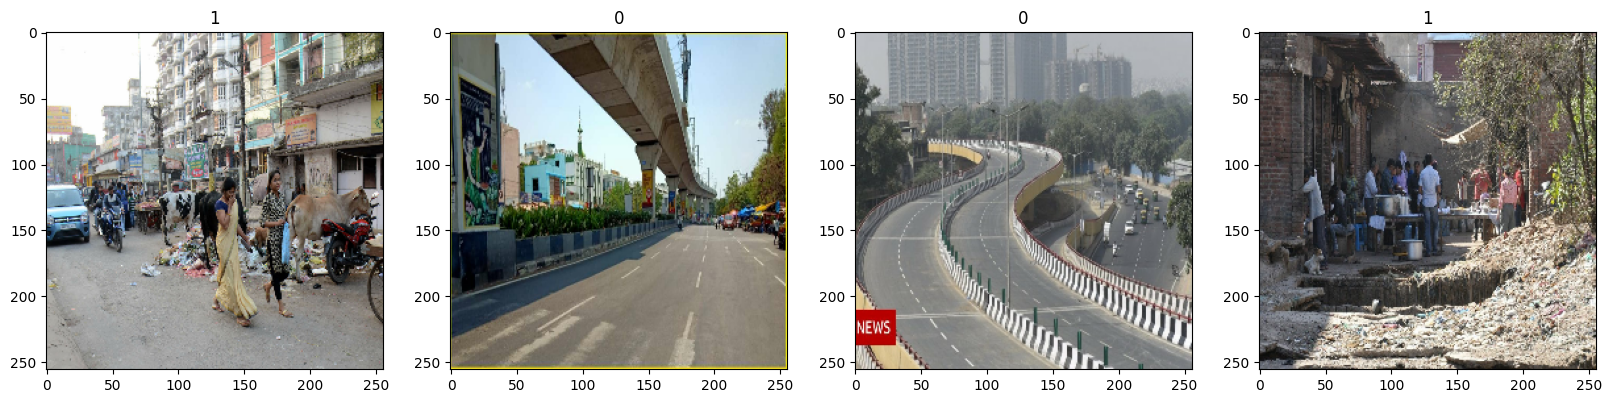

In [11]:
#this is one way too see wich classes belong 0 and 1
# 1 is littered
# 0 is clean
# we can see that the images have the same size
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])


# Preprocess Data
Divide all the data to get the smallest values

In [12]:
# scale data so we can read faster from the disk all the data
# all the images are between 0 and 1
data = data.map(lambda x,y: (x/255, y))

#data.as_numpy_iterator().next()[0].max()

1.0

In [13]:
tam_data = len(data) #== 7
train_size = int(tam_data*0.7) #4 batch for train
val_size = int(tam_data*0.2)+1 #1 batch for validation
test_size = int(tam_data*0.1)+1 #1 batch for testing

In [14]:
#this will take the batches for each step of the model
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)


# Deep Model


In [15]:
model = Sequential()

#this one have 16 filters and the filter have 3x3 pixels
# and move one pixel each time

#with relu activation any output below 0 is converted to 0 and preseved the positive value
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(15, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))

#sigmoid reshape the output to a better result
#have one single layer at final
# convert the output to 0 or 1
# 1 - littered
# 0 - clean
model.add(Dense(1, activation='sigmoid'))

In [16]:
#adam - optmizer
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
#to see all the layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 15)        4335      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 15)        0

### Train

In [17]:
history = model.fit(train, epochs=20, validation_data=val)

Epoch 1/20
4/4 [==============================] - 20s 2s/step - loss: 0.8850 - accuracy: 0.5312 - val_loss: 0.8240 - val_accuracy: 0.4375
Epoch 2/20
4/4 [==============================] - 4s 731ms/step - loss: 0.7342 - accuracy: 0.5391 - val_loss: 0.6834 - val_accuracy: 0.4531
Epoch 3/20
4/4 [==============================] - 4s 723ms/step - loss: 0.6552 - accuracy: 0.5938 - val_loss: 0.6312 - val_accuracy: 0.7812
Epoch 4/20
4/4 [==============================] - 6s 903ms/step - loss: 0.6059 - accuracy: 0.7266 - val_loss: 0.5607 - val_accuracy: 0.7656
Epoch 5/20
4/4 [==============================] - 5s 901ms/step - loss: 0.5472 - accuracy: 0.7422 - val_loss: 0.5663 - val_accuracy: 0.6562
Epoch 6/20
4/4 [==============================] - 4s 770ms/step - loss: 0.4813 - accuracy: 0.7578 - val_loss: 0.4194 - val_accuracy: 0.8438
Epoch 7/20
4/4 [==============================] - 6s 915ms/step - loss: 0.4001 - accuracy: 0.8438 - val_loss: 0.3295 - val_accuracy: 0.8594
Epoch 8/20
4/4 [======

In [20]:
# see all the values
# loss, accuracy, val_loss,val_accuracy
history.history

{'loss': [0.8849627375602722,
  0.7342370748519897,
  0.6551518440246582,
  0.6059082746505737,
  0.54716557264328,
  0.48132169246673584,
  0.4001244306564331,
  0.31470176577568054,
  0.27878278493881226,
  0.20999372005462646,
  0.13120092451572418,
  0.09892728924751282,
  0.08756878972053528,
  0.12082480639219284,
  0.09100005030632019,
  0.059482261538505554,
  0.03182632476091385,
  0.02171490155160427,
  0.023777928203344345,
  0.029368024319410324],
 'accuracy': [0.53125,
  0.5390625,
  0.59375,
  0.7265625,
  0.7421875,
  0.7578125,
  0.84375,
  0.875,
  0.890625,
  0.921875,
  0.96875,
  0.9765625,
  0.9765625,
  0.96875,
  0.9765625,
  0.984375,
  1.0,
  1.0,
  1.0,
  0.984375],
 'val_loss': [0.8240418434143066,
  0.6833556890487671,
  0.6311809420585632,
  0.5606563091278076,
  0.5663472414016724,
  0.4193931818008423,
  0.32952696084976196,
  0.19509544968605042,
  0.23657654225826263,
  0.16944620013237,
  0.14981648325920105,
  0.11455868929624557,
  0.1547186970710754

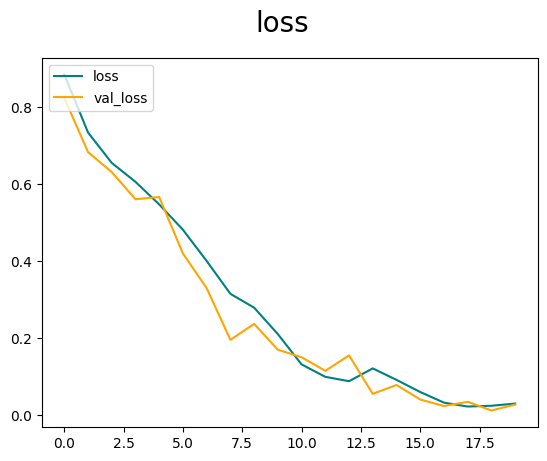

In [21]:
#loss graph
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

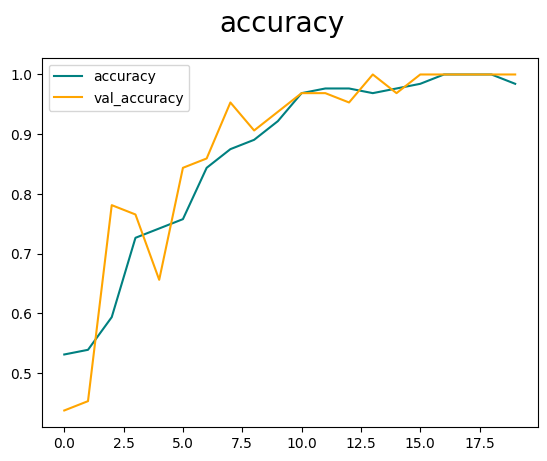

In [22]:
#accuracy
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

### Evaluate Performance


In [26]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
  X,y = batch
  yhat = model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

1/1 [==============================] - 0s 286ms/step


In [ ]:
#upload a Littered road
files.upload()

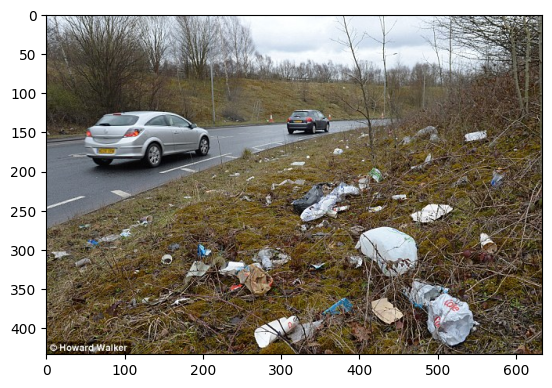

In [36]:
img = cv2.imread('2749C52800000578-3025774-image-a-1_1428172476891-24412522.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [37]:
# resize the image
resize = tf.image.resize(img, (256,256))

In [38]:
#predict
np.expand_dims(resize, 0) #put in a list

yhat = model.predict(np.expand_dims(resize/255,0))

if yhat > 0.5:
  print('The road is dirty')
else:
  print('the road is clean')

1/1 [==============================] - 0s 26ms/step
the road is clean
